# Plot bar chart comparing fluid compositions

In [20]:
%load_ext autoreload
%autoreload 2
#%run ct_data.py '../crunchtope_model/hydrothermal_crunch.nc' -c pH totcon
%run pf_data.py '../pflo_revisions/hydrothermal.nc'
%run figures.py
import cmcrameri.cm as cm
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Zoisite', 'Chamosite', 'Clinochlore', 'Analcime', 'Anhydrite', 'Calcite', 'Annite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite', 'Clinochlore'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'inosilicates': ['Prehnite'], 'talc': ['Talc'], 'epidotes': ['Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite'], 'quartz': ['Quartz'], 'mica': ['Annite']}


In [21]:
vent_fluid = {'H+': 6.31e-5, 'Mg++': 1.0e-12, 'Ca++': 40e-3, 'HCO3-': 2.0e-8, 'SO4--': 1e-6, 'SiO2(aq)': 2.02e-2, 'Na+': 0.497}
seawater = {'H+': 10**(-8.15), 'Mg++': 0.0528, 'Ca++': 0.0103, 'HCO3-': 0.002, 'SO4--': 0.0282, 'SiO2(aq)': 0, 'Na+': 0.475}

In [22]:
pf_data = pf_data.sel(file_number=6)

# Prepend 'Total_' to each key and return as a list
pf_keys = ['Total_' + key for key in vent_fluid.keys()]
pf_keys.remove('Total_H+')
pf_keys.append('pH')
pf_vals = pf_data.sel(x=0, z=1000, time=1000, method='nearest')[pf_keys]

# Convert values of each variable to a list
pf_dict = {var: pf_vals[var].values.tolist() for var in pf_vals.data_vars}
# Output the result
pf_values = list(pf_dict.values())
pf_values = np.array(pf_values) * 1000
pf_values = pf_values.flatten()
pf_values[-1] = pf_values[-1] / 1000

[[ 497.     0.    24.     0.     0.    12.9    4. ]
 [-497.     0.    27.7    0.     0.     0.8    6. ]]


ValueError: 'yerr' must not contain negative values

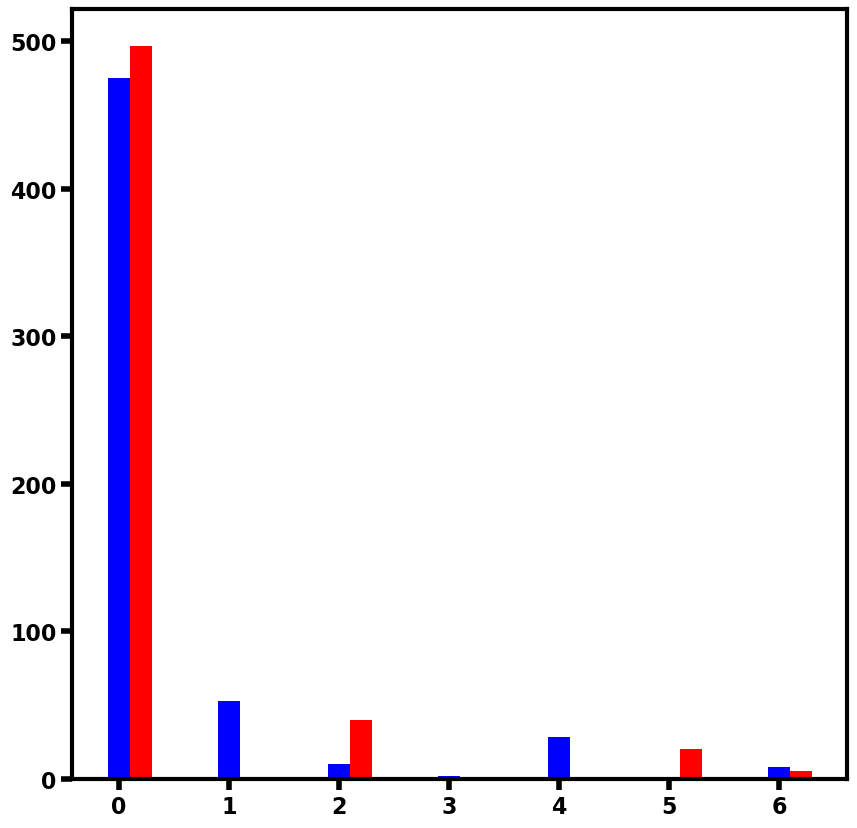

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Set global plot parameters
mpl.rcParams['axes.linewidth'] = 3

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))
ax.grid(False)
ax.tick_params(length=8, width=4)

# Helper function to set tick label styles
def set_tick_styles(axis, fontsize, fontweight):
    for tick in axis.get_major_ticks():
        tick.label1.set_fontweight(fontweight)
        tick.label1.set_fontsize(fontsize)
        tick.label2.set_fontweight(fontweight)

set_tick_styles(ax.xaxis, 16, 'bold')
set_tick_styles(ax.yaxis, 16, 'bold')

# Define chemical species for the x-axis labels
chemical_species = ['Na$^{\\mathbf{+}}$',
    'Mg$^{\\mathbf{2+}}$', 'Ca$^{\\mathbf{2+}}$', 'HCO$\\mathbf{_3^-}$', 
    'SO$\\mathbf{_4^{2-}}$', 'H$\\mathbf{_4}$SiO$\\mathbf{_{4(aq)}}$', 'pH'
]

# Data for different fluid types; pf_values is assumed to be defined as a numpy array
chemistry_data = {
    'Seawater': np.array([475, 52.8, 10.3, 2.02, 28.2, 0, 8.15]),
    'Vent Fluid': np.array([497, 0, 40, 0, 0, 20.2, 5.5]),
    'PFLOTRAN Model': np.array(pf_values)
}

# Define error bar limits for the Vent Fluid data
# The lower and upper bounds for each chemical species are provided,
# and we compute the error margins relative to the Vent Fluid values.
vent_data = chemistry_data['Vent Fluid']
vent_lower_bounds = np.array([497, 0, 16, 0, 0, 7.3, 1.5])
vent_upper_bounds = np.array([497, 0, 67.7, 0, 0, 21, 11.5])
error_lower = vent_data - vent_lower_bounds
error_upper = vent_upper_bounds - vent_data
error_limits = np.vstack((error_lower, error_upper))
print(error_limits)

# Bar plot settings
num_species = len(chemical_species)
x_positions = np.arange(num_species)
bar_width = 0.2

# Colors and hatch patterns for each dataset (adjust or add more if needed)
colors = ['b', 'r', 'y', 'g']
hatches = [None, None, None, None]

# Plot each dataset as a set of bars
for idx, (label, data) in enumerate(chemistry_data.items()):
    offset = idx * bar_width
    ax.bar(x_positions + offset, data, bar_width, label=label, color=colors[idx], hatch=hatches[idx])
    # Add error bars for the Vent Fluid data
    if label == 'Vent Fluid':
        ax.errorbar(x_positions + offset, data, yerr=error_limits, fmt='none', c='k', capsize=10)

# Create a secondary y-axis for the pH data
ax2 = ax.twinx()
ax2.set_ylim(0, 8)
ax2.set_ylabel('pH', size=20, weight='bold')
set_tick_styles(ax2.yaxis, 20, 'bold')

# Set the primary y-axis label and x-axis tick labels
ax.set_ylabel('Concentration / mM', size=20, weight='bold')
ax.set_xticks(x_positions + bar_width)
ax.set_xticklabels(chemical_species)

# Add a legend
ax.legend(loc='upper right', ncols=1, prop={'weight': 'bold', 'size': 15})

# Save the figure
fig.savefig('output/figure_s1.png', dpi=300)
